In [1]:
from mdagent import MDAgent
import os 
import mdtraj as md

In [2]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from robustness_prompts import get_prompt

prompt_8_descriptive = get_prompt("descriptive", 8)
prompt_8_natural = get_prompt("natural", 8)

prompt_8_descriptive, prompt_8_natural

('Complete all of the following tasks: 1. Download the PDB file 1LYZ. 2. Report the secondary structure assignments of the PDB structure. 3. Simulate for 1 ps at 300 K. 4. Compute the RMSD of the simulation at 300 K. 5. Compute the radius of gyration over time for the simulation at 300 K. 6. Simulate for 1 ps at 400 K. 7. Compute the RMSD of the simulation at 400 K. 8. Compute the radius of gyration over time for the simulation at 400 K.',
 'Simulate 1LYZ for 1 ps at 300K and 400K. Report the secondary structure assignments of the PDB structure, and compute the RMSD and radius of gyration of both simulations.')

Required Tasks:
- Download
- SS Analysis
- Simulation_1
- RMSD_1
- Rgy_1
- Simulation_2
- RMSD_2
- Rgy_2

In [3]:
llm_model = "claude-3-5-sonnet-20240620"
tools = "all"

In [4]:
agent_1 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools)
agent_1.run(prompt_8_descriptive)

Thought: To complete all these tasks, I'll need to use several tools in sequence. Let's start with downloading the PDB file for 1LYZ.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```PDB file found with this ID: 1LYZ
Thought: Great, we've successfully downloaded the PDB file for 1LYZ. Now, let's move on to the next task, which is to report the secondary structure assignments of the PDB structure.

Action:
```
{
    "action": "ComputeDSSP",
    "action_input": {
        "traj_file": "1LYZ_184528",
        "top_file": "1LYZ_184528",
        "target_frames": "first"
    }
}
```Thought: We've successfully obtained the secondary structure assignments for 1LYZ. Now, let's proceed with the simulation tasks. We'll start by setting up and running a short simulation at 300 K for 1 ps.

Action:
```
{
    "action": "SetUpandRunFunction",
    "action_input": {
        "pdb_id": "1LYZ_184528",
        "forcefield_files": ["amber14-all.xml", "amber14/tip3pfb.xml"],
  

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [5]:
registry_1 = agent_1.path_registry
print(registry_1.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_184528: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_184528
 rec0_184531: dssp values for trajectory with id: 1LYZ_184528
 1LYZ_184543: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_184547: Initial positions for simulation sim0_184547
 sim0_184547: Basic Simulation of Protein 1LYZ_184543
 rec0_184551: Simulation trajectory for protein 1LYZ_184543 and simulation sim0_184547
 rec1_184551: Simulation state log for protein 1LYZ_184543 and simulation sim0_184547
 rec2_184551: Simulation pdb frames for protein 1LYZ_184543 and simulation sim0_184547
 rmsd_184547: RMSD for 184547
 fig0_185032: RMSD plot for 184547
 rgy_rec0_184551: Radii of gyration per frame for rec0_184551
 fig0_185036: Plot of radii of gyration over time for rec0_184551
 top_sim0_185041: Initial positions for simulation sim0_185041
 sim0_185041: Basic Simulatio

In [6]:
# make sure pdb was downloaded
assert os.path.exists(registry_1.get_mapped_path("1LYZ_184528"))

In [7]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_1)
dssp._run(traj_file= "1LYZ_184528", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [8]:
# make sure trajectory and topology exist (sim1)
traj_path_1_1 = registry_1.get_mapped_path("rec0_184551")
top_path_1_1 = registry_1.get_mapped_path("top_sim0_184547")

assert os.path.exists(traj_path_1_1)
assert os.path.exists(top_path_1_1)

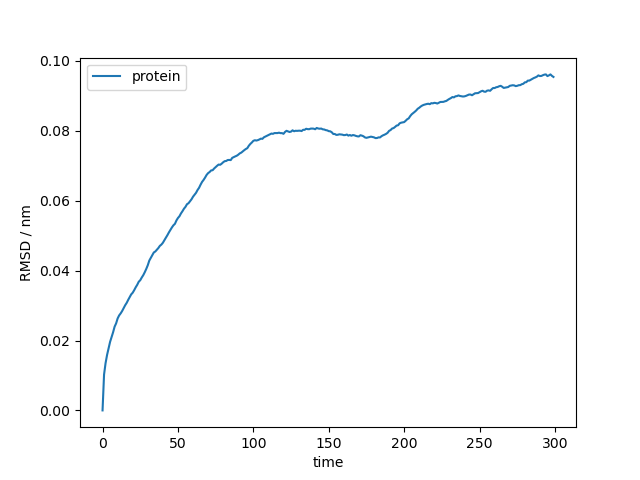

In [9]:
# make sure rmsd plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_185032')) 

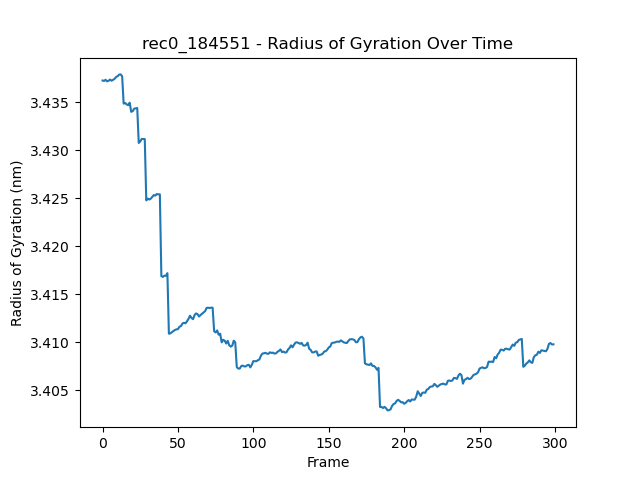

In [10]:
# make sure rgy plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_185036'))

In [11]:
# make sure trajectory and topology exist (sim2)
traj_path_1_2 = registry_1.get_mapped_path("rec0_185045")
top_path_1_2 = registry_1.get_mapped_path("top_sim0_185041")

assert os.path.exists(traj_path_1_2)
assert os.path.exists(top_path_1_2)

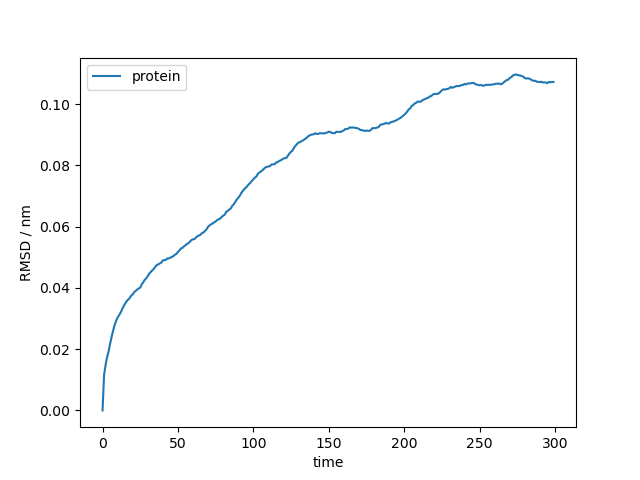

In [12]:
# make sure rmsd plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_185514'))

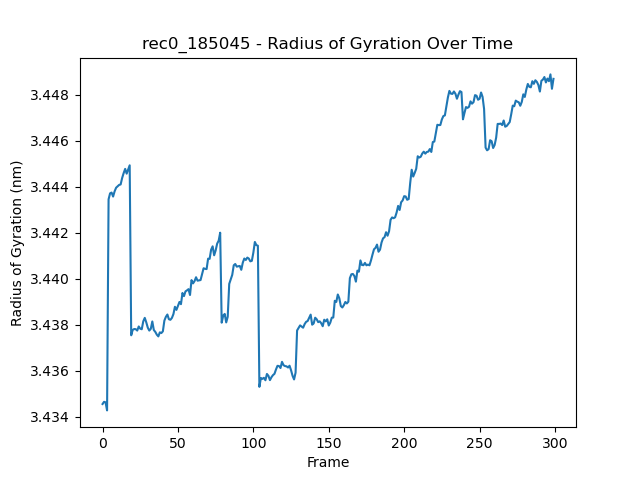

In [15]:
# make sure rgy plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_185518'))

In [16]:
agent_2 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools)
agent_2.run(prompt_8_natural)

Thought: To address this question, we need to follow several steps. First, we'll download the PDB file for 1LYZ, then set up and run simulations at 300K and 400K. After that, we'll analyze the secondary structure, RMSD, and radius of gyration for both simulations. Let's start by downloading the PDB file.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```PDB file found with this ID: 1LYZ
Thought: Great, we have successfully downloaded the PDB file for 1LYZ. Now, let's set up and run the simulations at 300K and 400K. We'll start with the 300K simulation.

Action:
```
{
    "action": "SetUpandRunFunction",
    "action_input": {
        "pdb_id": "1LYZ_190533",
        "forcefield_files": ["amber14-all.xml", "amber14/tip3pfb.xml"],
        "system_params": {
            "nonbondedMethod": "PME",
            "nonbondedCutoff": "1 * nanometers",
            "constraints": "HBonds",
            "rigidWater": true,
            "ewaldErrorTolerance": 0.0005,
    

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [17]:
registry_2 = agent_2.path_registry
print(registry_2.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_190533: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_190533
 1LYZ_190544: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_190549: Initial positions for simulation sim0_190549
 sim0_190549: Basic Simulation of Protein 1LYZ_190544
 rec0_190553: Simulation trajectory for protein 1LYZ_190544 and simulation sim0_190549
 rec1_190553: Simulation state log for protein 1LYZ_190544 and simulation sim0_190549
 rec2_190553: Simulation pdb frames for protein 1LYZ_190544 and simulation sim0_190549
 top_sim0_191204: Initial positions for simulation sim0_191204
 sim0_191204: Basic Simulation of Protein 1LYZ_190544
 rec0_191208: Simulation trajectory for protein 1LYZ_190544 and simulation sim0_191204
 rec1_191208: Simulation state log for protein 1LYZ_190544 and simulation sim0_191204
 rec2_191208: Simulation pdb frames for protein 1LYZ_1905

In [20]:
# make sure pdb was downloaded
assert os.path.exists(registry_2.get_mapped_path("1LYZ_190533"))

In [21]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_2)
dssp._run(traj_file= "1LYZ_190533", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [22]:
# make sure trajectory and topology exist (sim1)
traj_path_2_1 = registry_2.get_mapped_path("rec0_190553")
top_path_2_1 = registry_2.get_mapped_path("top_sim0_190549")

assert os.path.exists(traj_path_2_1)
assert os.path.exists(top_path_2_1)

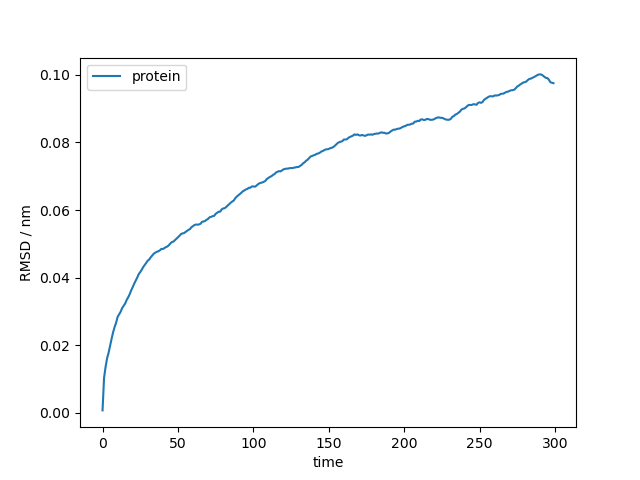

In [23]:
# make sure rmsd plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_191716'))

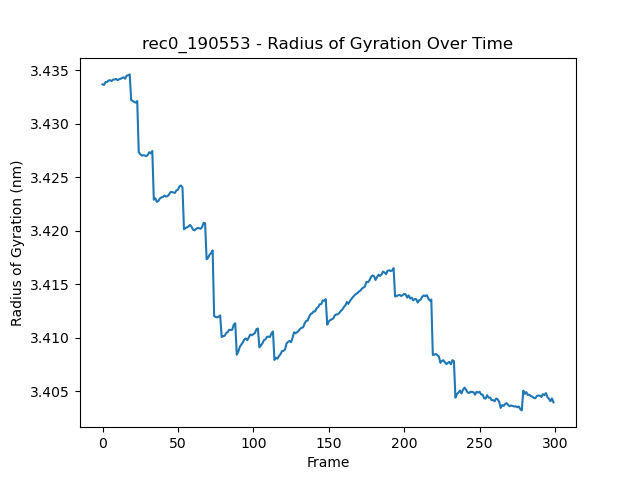

In [24]:
# make sure rgy plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_191720'))

In [25]:
# make sure trajectory and topology exist (sim1)
traj_path_2_2 = registry_2.get_mapped_path("rec0_191208")
top_path_2_2 = registry_2.get_mapped_path("top_sim0_191204")

assert os.path.exists(traj_path_2_2)
assert os.path.exists(top_path_2_2)

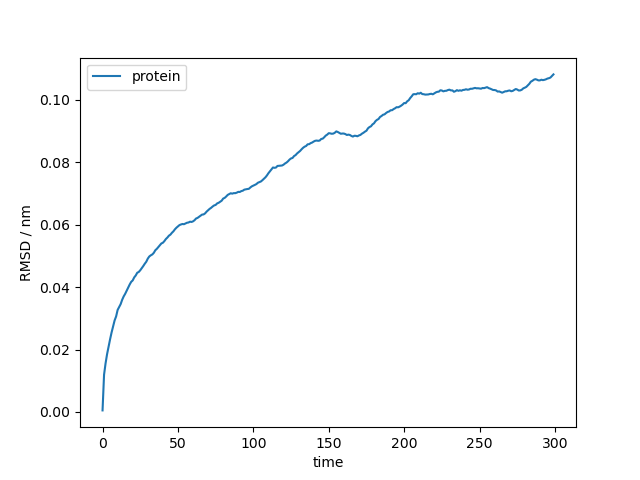

In [18]:
# make sure rmsd plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_191726'))

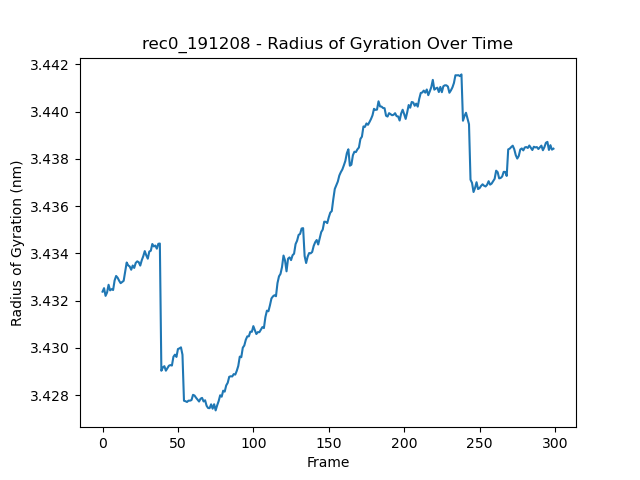

In [19]:
# make sure rgy plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_191730'))